<a href="https://colab.research.google.com/github/CakeNuthep/Diffusion-Models-pytorch/blob/main/ddpm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/CakeNuthep/Diffusion-Models-pytorch.git

Cloning into 'Diffusion-Models-pytorch'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 79 (delta 10), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (79/79), 41.86 MiB | 10.16 MiB/s, done.


In [2]:
!unzip "/content/Diffusion-Models-pytorch/data/Linnaeus 5 64X64.zip" -d "/content/Diffusion-Models-pytorch/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/822_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/823_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/824_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/825_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/826_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/827_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/828_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/829_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/83_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64X64/train/berry/830_64.jpg  
  inflating: /content/Diffusion-Models-pytorch/Linnaeus 5 64

In [3]:
%cd "/content/Diffusion-Models-pytorch"

/content/Diffusion-Models-pytorch


In [4]:
class argument:
  def __init__(self,run_name=None,epochs=None,batch_size=None,image_size=None,dataset_path=None,device=None,lr=None):
    super().__init__()
    self.run_name = run_name
    self.epochs = epochs
    self.batch_size = batch_size
    self.image_size = image_size
    self.dataset_path = dataset_path
    self.device = device
    self.lr = lr

In [5]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
from utils import *
from modules import UNet
import logging
from torch.utils.tensorboard import SummaryWriter

In [28]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def revert(self,model,n):
        logging.info(f"Sampling {n} new images....")
        result = []
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                if(i % 100 == 0):
                    result.append(x)
        model.train()
        result.append(x)
        result = torch.cat(result)
        result = (result.clamp(-1, 1) + 1) / 2
        result = (result * 255).type(torch.uint8)
        return result

    def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [35]:
def train(args,model_path=None):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)
    model = UNet(device=device).to(device)
    if(model_path):
        ckpt = torch.load(model_path)
        model.load_state_dict(ckpt)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

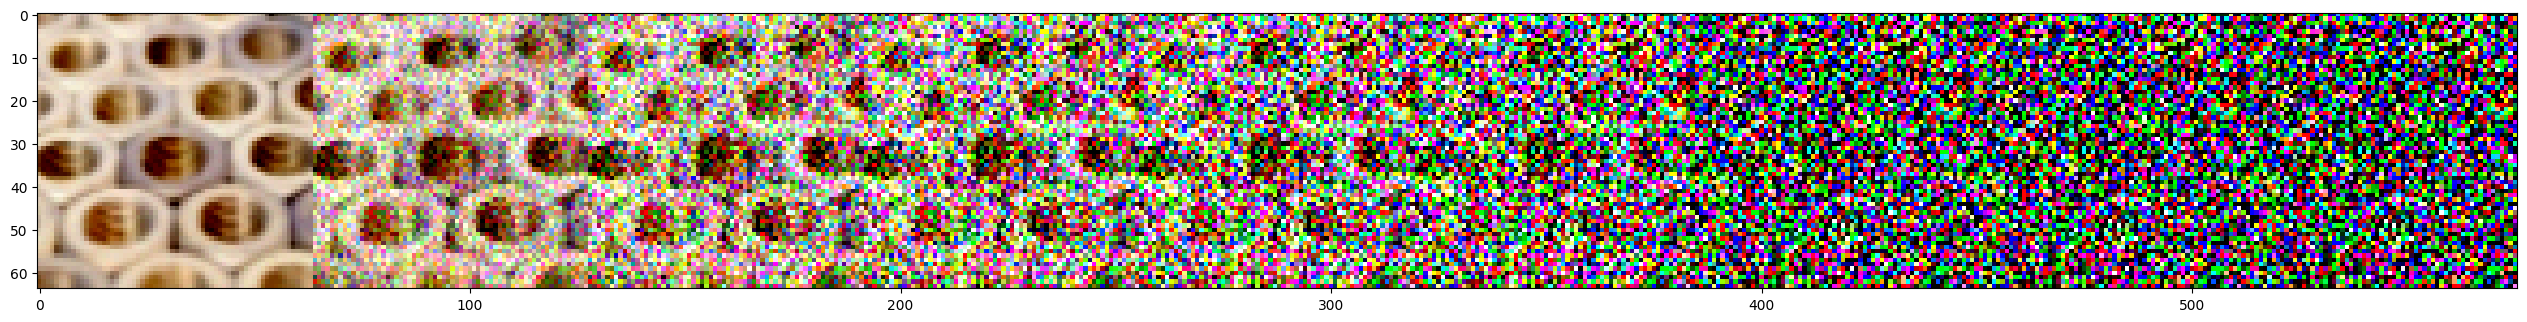

In [29]:
from utils import get_data
from torchvision.utils import save_image
args = argument()
args.batch_size = 1
args.image_size = 64
args.device = "cuda"
args.lr = 3e-4
args.dataset_path = "/content/Diffusion-Models-pytorch/Linnaeus 5 64X64"
dataloader = get_data(args)
image = next(iter(dataloader))[0]
image = image.to(args.device)
t = torch.Tensor([0, 50, 100, 150, 200, 300, 600, 700, 999]).long()
diffusion = Diffusion(img_size=args.image_size, device=args.device)
noised_image, _ = diffusion.noise_images(image, t)
plot_images(noised_image)

In [9]:
args = argument()
args.run_name = "DDPM_Uncondtional"
args.epochs = 50
args.batch_size = 6    #12
args.image_size = 64
args.dataset_path = "/content/Diffusion-Models-pytorch/Linnaeus 5 64X64"
args.device = "cuda"
args.lr = 3e-4
train(args,model_path="/content/Diffusion-Models-pytorch/models/DDPM_Uncondtional/ckpt.pt")

100%|██████████| 1334/1334 [01:45<00:00, 12.70it/s, MSE=0.00885]
999it [00:14, 67.39it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.00825]
999it [00:14, 67.50it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0181]
999it [00:14, 67.83it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0295]
999it [00:14, 67.27it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.93it/s, MSE=0.00503]
999it [00:14, 67.40it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0025]
999it [00:14, 67.78it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0736]
999it [00:14, 67.73it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0092]
999it [00:14, 67.53it/s]
100%|██████████| 1334/1334 [01:42<00:00, 12.96it/s, MSE=0.0125]
999it [00:14, 68.04it/s]
100%|██████████| 1334/1334 [01:42<00:00, 13.00it/s, MSE=0.0127]
999it [00:14, 68.44it/s]
100%|██████████| 1334/1334 [01:42<00:00, 13.00it/s, MSE=0.0273]
999it [00:14, 68.49it/s]
100%|██████████| 1

999it [00:31, 31.30it/s]


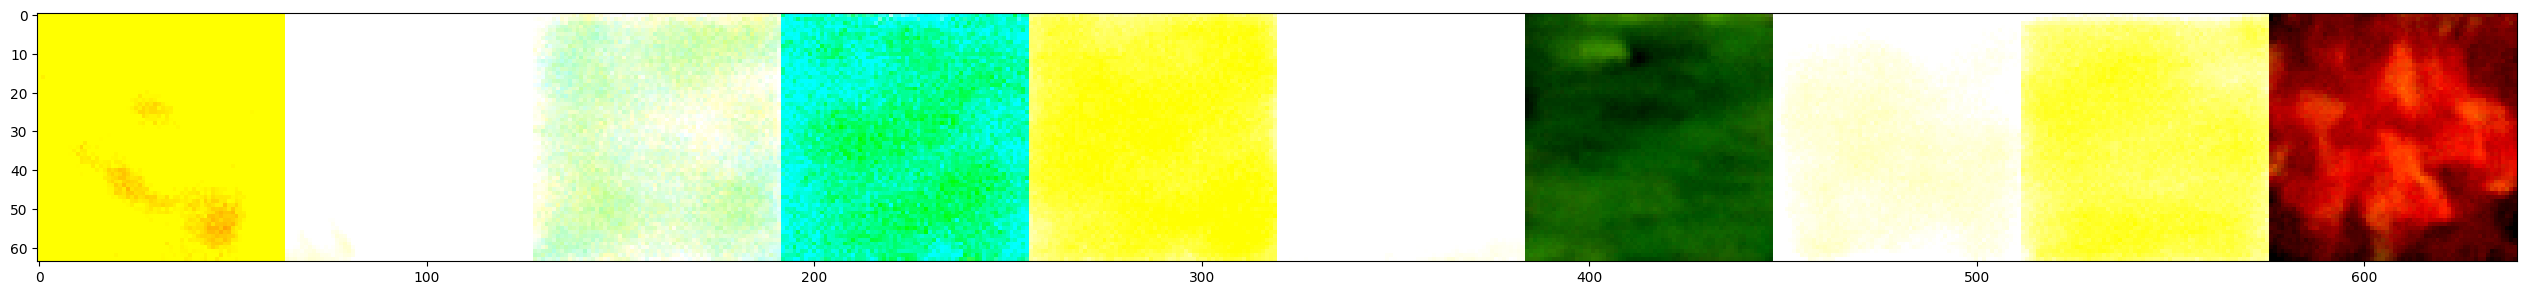

In [40]:
model = UNet().to(args.device)
ckpt = torch.load("/content/Diffusion-Models-pytorch/models/DDPM_Uncondtional/ckpt.pt")
model.load_state_dict(ckpt)
x = diffusion.sample(model, n=10)
plot_images(x)

999it [00:12, 78.27it/s]


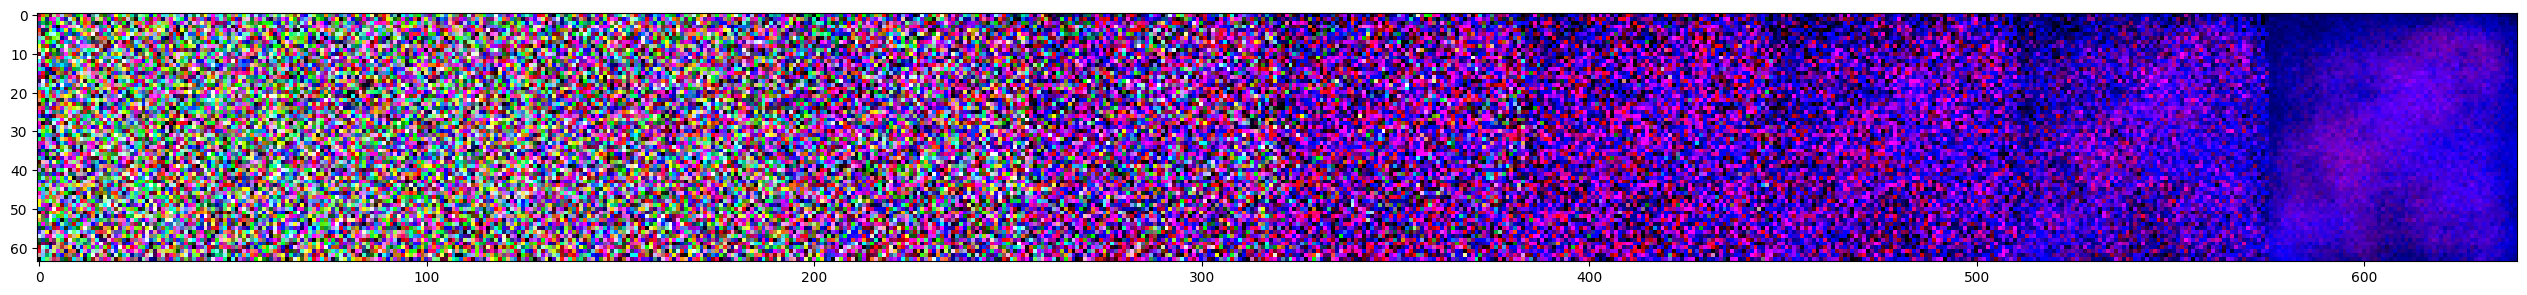

In [33]:
denoise_img = diffusion.revert(model, n=1)
plot_images(denoise_img)

In [27]:
denoise_img.shape

torch.Size([9, 3, 64, 64])

In [36]:
args = argument()
args.run_name = "DDPM_Uncondtional"
args.epochs = 10
args.batch_size = 6    #12
args.image_size = 64
args.dataset_path = "/content/Diffusion-Models-pytorch/Linnaeus 5 64X64"
args.device = "cuda"
args.lr = 3e-4
train(args,"/content/Diffusion-Models-pytorch/models/DDPM_Uncondtional/ckpt.pt")

100%|██████████| 1334/1334 [01:43<00:00, 12.88it/s, MSE=0.0119]
999it [00:14, 67.35it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.88it/s, MSE=0.00142]
999it [00:14, 67.79it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.90it/s, MSE=0.000931]
999it [00:14, 67.90it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.89it/s, MSE=0.00079]
999it [00:14, 67.56it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.91it/s, MSE=0.00858]
999it [00:14, 67.44it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.90it/s, MSE=0.000428]
999it [00:14, 67.80it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.86it/s, MSE=0.00464]
999it [00:14, 67.23it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.85it/s, MSE=0.00621]
999it [00:14, 66.86it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.89it/s, MSE=0.0266]
999it [00:14, 67.33it/s]
100%|██████████| 1334/1334 [01:43<00:00, 12.93it/s, MSE=0.00676]
999it [00:14, 68.41it/s]
